In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qgutils as qg
import pickle
from matplotlib.offsetbox import AnchoredText
from scipy import signal

### Note on diff runs
- **_newent**: modified entrainement to dissociate between upwelling (no entrainement) and downwelling (entrainement following (4.32) of Hogg et al. (2014) )
- **_dt10**: Temperature diff between first and second QG ocean layer (i.e. $\Delta_1^o T$ in (4.32) of Hogg et al. (2014)) is set to 10 degC, instead of 5 degC for other runs. 
- other runs, in particular spinup and reference runs, DO NOT HAVE entoc outputed (in ocpo.nc) so that we cannot compute full LEC for these runs.

*Hogg, A. M., Blundell, J. R., Dewar, W. K., & Killworth, P. D. (2014). Formulation and users’ guide for Q-GCM.*

In [2]:
def intz(psi, dh):
    '''
    Compute vertical integral of a field

    if the field is defined on p-levels, the integral is the usual integral
    if the field is defined on b-levels, we assume that psi = 0 at
    the upper and lower boundaries


    Parameters
    ----------

    psi : array [nz, ny,nx] for p-level field or array [nz-1, ny,nx] for b-level field
    dh : array [nz], *dh is the layer thickness of the p-level* (no matter what)

    Returns
    -------

    psi_i = scalar

    '''
    si = psi.shape
    nl0 = si[0]
    N = si[-1]
    nl = len(dh)

    # total H even for b-levels
    Ht = np.sum(dh)

    dhl = np.copy(dh)
    if nl0 == nl-1:
        dhl = 0.5*(dh[1:] + dh[:-1])

    psi_i = np.sum(psi*dhl[:,None,None], axis=0)

    return psi_i

In [3]:
dir_abs = '/home2/datawork/qjamet/qgcm-data/double_gyre_coupled/outdata_12_dt10/'
dir_rel = '/home2/datawork/qjamet/qgcm-data/double_gyre_coupled/outdata_12_dt10_tdiff/'
dir_fig = '/home2/datahome/qjamet/Figures/LorenzQG/'
filep = 'ocpo.nc'
filet = 'ocsst.nc'

pfiles_abs = [dir_abs + filep]
ffiles_abs = [dir_abs + filet]
pfiles_rel = [dir_rel + filep]
ffiles_rel = [dir_rel + filet]

# physical parameters
gp = np.array([0.025, 0.0125])
dh = np.array([350., 750., 2900])
f0 =  9.37456E-05
beta = 1.75360E-11
#toc = np.array([-13.1693, -23.1693, -24.1693])# dt10
Delta = 5000
d_e = 5
nu = 0
nu4 = 2.e9
nu_in_b=False
rho=1e3

# numerical parameters
interp=False

# derived parameters
N2 = qg.gprime2N2(dh,gp)
bf = d_e*f0/(2*dh[-1])

si_t = qg.read_time(pfiles_abs)
p = qg.load_generic(pfiles_abs, 0, 'p', 1/f0, si_t=si_t, interp=interp)
nl,N,naux = p.shape
#
N2,f0 = qg.reshape3d(dh,N2,f0)

xx = np.arange(Delta/2, N*Delta, Delta)/1000
yy = np.arange(Delta/2, N*Delta, Delta)/1000

# Load pre-computed estimates

In [4]:
dir_in = '/home2/datawork/qjamet/qgcm-data/double_gyre_coupled/data/'
fileN1 = str("%s/LEC_2d_maps_spectral_fluxes_%s.pkl" % (dir_in, 'abs'))
fileN2 = str("%s/LEC_2d_maps_spectral_fluxes_%s.pkl" % (dir_in, 'rel'))
with open(fileN1, 'rb') as f:
    lec_abs = pickle.load(f)
with open(fileN2, 'rb') as f:
    lec_rel = pickle.load(f)

# Compute mean

In [5]:
p_me_abs = np.zeros((nl,N,N))
p_me_rel = np.zeros((nl,N,N))
n_me = 1
for it in range(0,si_t):
    print("Loop 1/2, file", pfiles_abs[0], it, "/", si_t, end="\r")
    #-- abs --
    p = qg.load_generic(pfiles_abs, it, 'p', rescale=1/f0, interp=interp, si_t=si_t, subtract_bc=True)
    p_me_abs += (p - p_me_abs)/n_me
    #-- rel --
    p = qg.load_generic(pfiles_rel, it, 'p', rescale=1/f0, interp=interp, si_t=si_t, subtract_bc=True)
    p_me_rel += (p - p_me_rel)/n_me
    #
    n_me += 1

# LEC

ABSOLUTE RUN


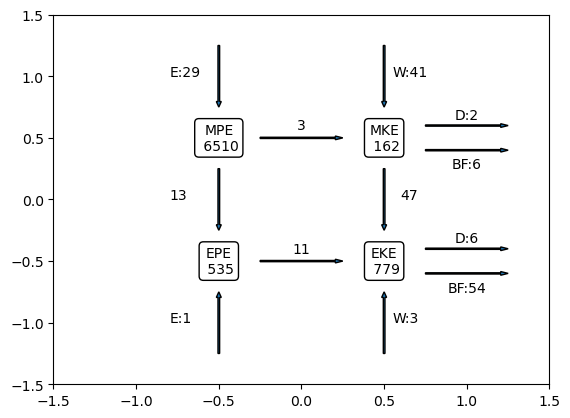

In [6]:
print("ABSOLUTE RUN")
qg.draw_lorenz_cycle(lec_abs, us = np.sqrt(1e15), ts = 1e6, rho = 1e3)


RELATIVE RUN


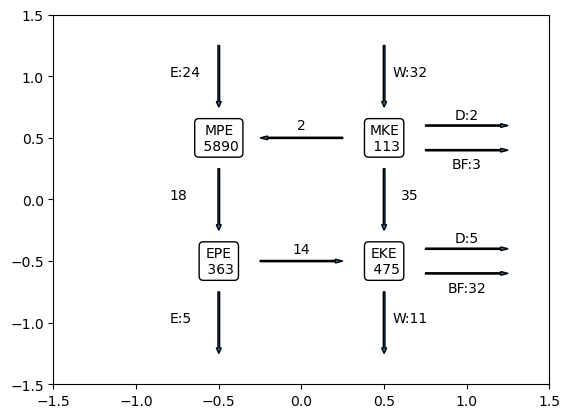

In [7]:
print("RELATIVE RUN")
qg.draw_lorenz_cycle(lec_rel, us = np.sqrt(1e15), ts = 1e6, rho = 1e3)

## Horizontal maps

In [8]:
#
def fig2hz(xx, yy, zz1, zz2, llev, units, save, figN, cbtype):
    '''
    Make 2-panel plot.
    '''
    if cbtype == 'max':
        cmap = 'hot_r'
    elif cbtype == 'both':
        cmap='RdBu_r'
    scaleF = rho*1e3
    fig = plt.figure(figsize=(12, 6))
    #
    ax1 = fig.add_subplot(1, 2, 1, adjustable='box', aspect=1)
    cs1 = ax1.contourf(xx, yy, zz1*scaleF, levels=llev, extend=cbtype, cmap=cmap)
    at1 = AnchoredText(r"ABS", prop=dict(size=15), frameon=True, loc='upper right')
    at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at1)
    ax1.set_xlabel('X-dir [km]', fontsize='x-large')
    ax1.set_ylabel('Y-dir [km]', fontsize='x-large')
    #
    ax2 = fig.add_subplot(1, 2, 2, adjustable='box', aspect=1)
    cs2 = ax2.contourf(xx, yy, zz2*scaleF, levels=llev, extend=cbtype, cmap=cmap)
    at2 = AnchoredText(r"REL", prop=dict(size=15), frameon=True, loc='upper right')
    at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax2.add_artist(at2)
    ax2.set_xlabel('X-dir [km]', fontsize='x-large')
    ax2.set_yticklabels([])
    #
    cb = fig.add_axes([0.92, 0.2, 0.01, 0.6])
    cb = fig.colorbar(cs1, ax=ax1, orientation='vertical', cax=cb)
    cb.set_label(str(r"%s" % (units)), fontsize='x-large')
    #
    if save:
        fig.savefig(str("%s.png" % (figN)), bbox_inches='tight')
        fig.savefig(str("%s.pdf" % (figN)), bbox_inches='tight')

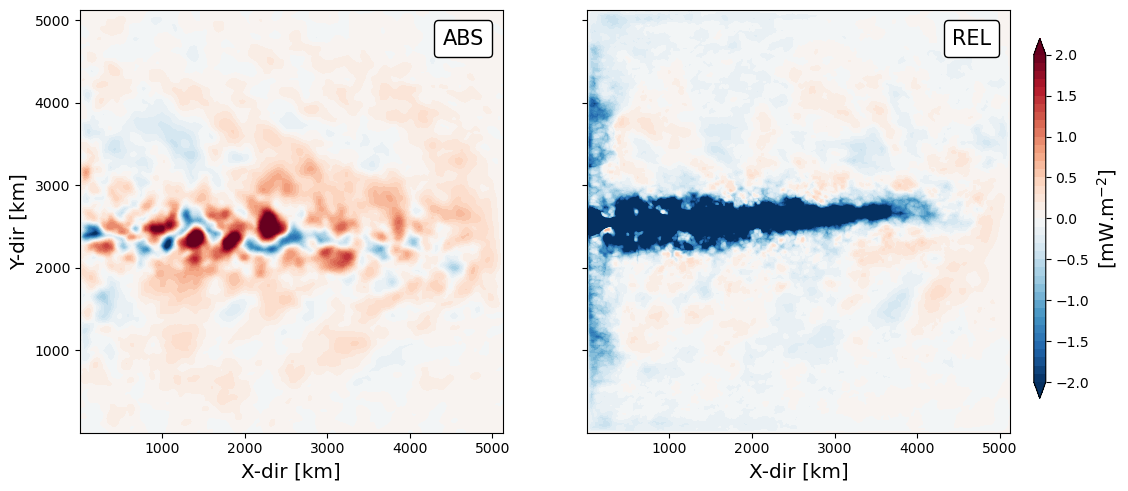

In [25]:
#-- Turbulent wind work --
figN = str( "%s/turbulent_ww_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, lec_abs["f2eke_map"], lec_rel["f2eke_map"], \
       np.arange(-2.0, 2.1, 0.1), "[mW.m$^{-2}$]", False, figN, cbtype='both')

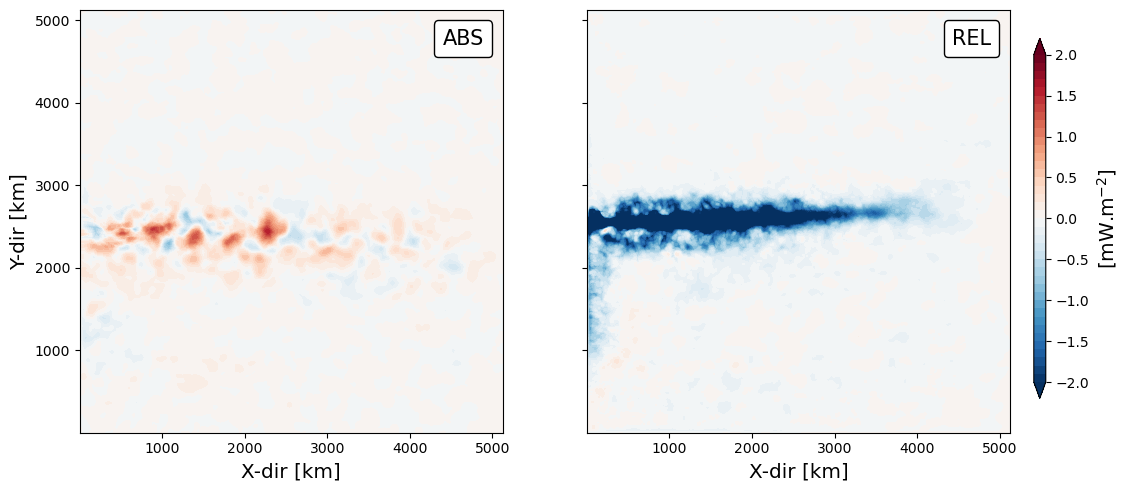

In [26]:
#-- Turbulent diabatic heating --
figN = str( "%s/turbulent_diab_heating_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, lec_abs["f2epe_map"], lec_rel["f2epe_map"], \
       np.arange(-2.0, 2.1, 0.1), "[mW.m$^{-2}$]", False, figN, cbtype='both')

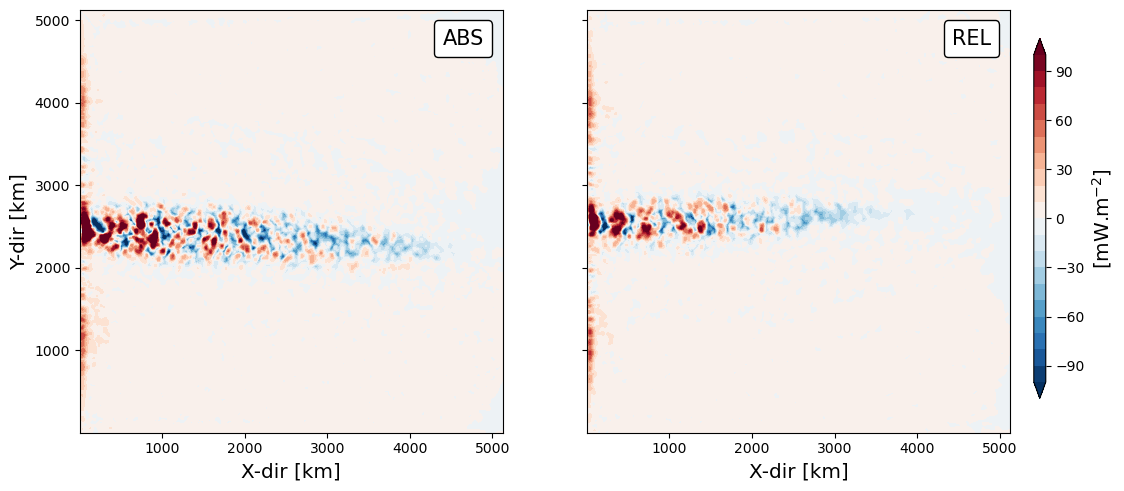

In [27]:
#-- w'b' --
figN = str( "%s/epe2eke_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, lec_abs["epe2eke_map"], lec_rel["epe2eke_map"], \
       np.arange(-100, 110, 10), "[mW.m$^{-2}$]", False, figN, cbtype='both')

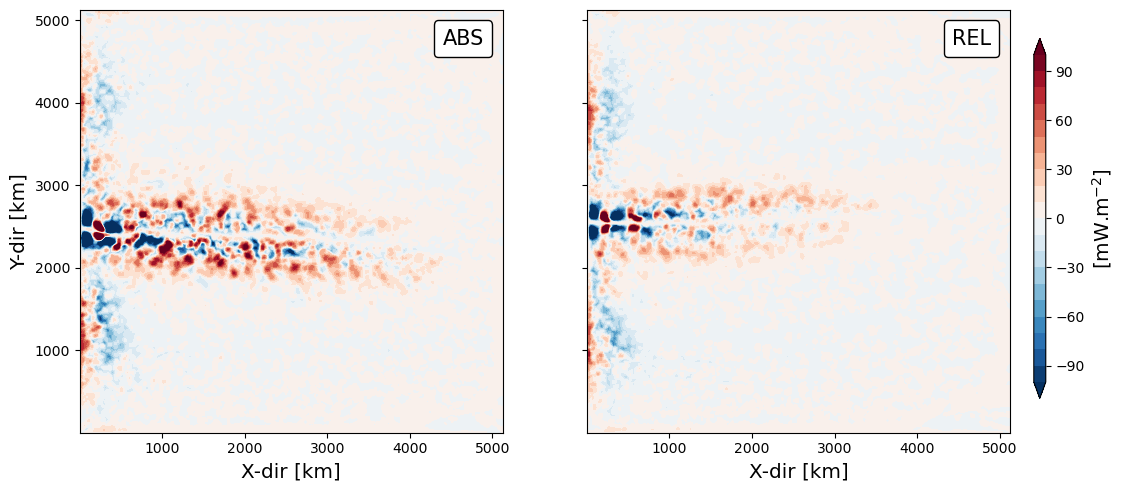

In [14]:
#-- P_MEC --
# should be -lec_abs["mpe2epe_map"] to match Alex (and spectral!) estimates?
# yes, because the way it is computed in energy.py includes a integration by part 
# (which vertically integrated full primitive is zero for b|_{z=\eta=H}=0)
figN = str( "%s/p_mec_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, -lec_abs["mpe2epe_map"], -lec_rel["mpe2epe_map"], \
       np.arange(-100, 110, 10), "[mW.m$^{-2}$]", True, figN, cbtype='both')

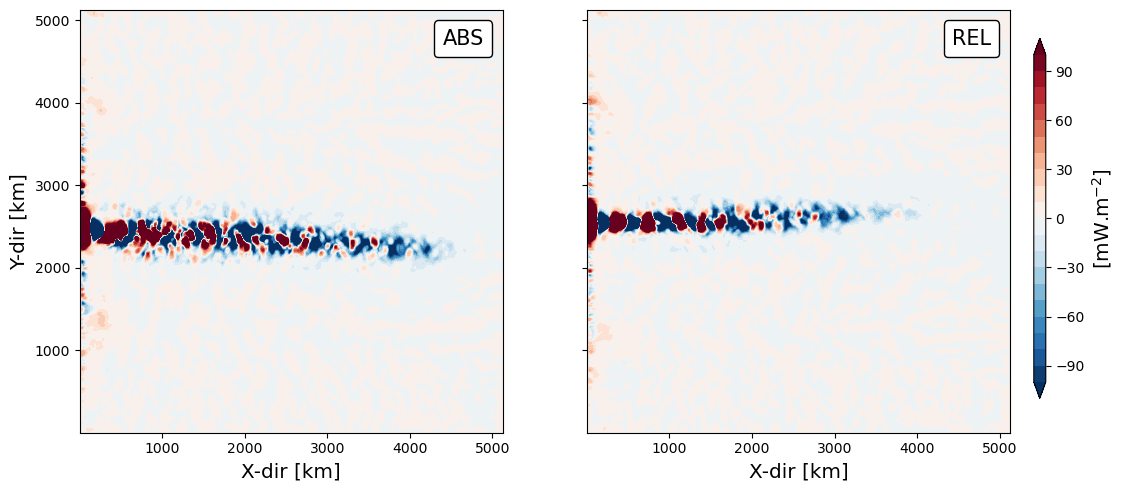

In [15]:
#-- P_EF --
figN = str( "%s/p_ef_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, -lec_abs["epe2mpe_map"], -lec_rel["epe2mpe_map"], \
       np.arange(-100, 110, 10), "[mW.m$^{-2}$]", True, figN, cbtype='both')

In [11]:
nxp = 400
p_xint = p_me_abs[0, 30:-30, 1:nxp].mean(axis=-1)
jjj = np.where( np.abs(p_xint) == np.abs(p_xint).min() )[0]

In [12]:
jjj

array([452])

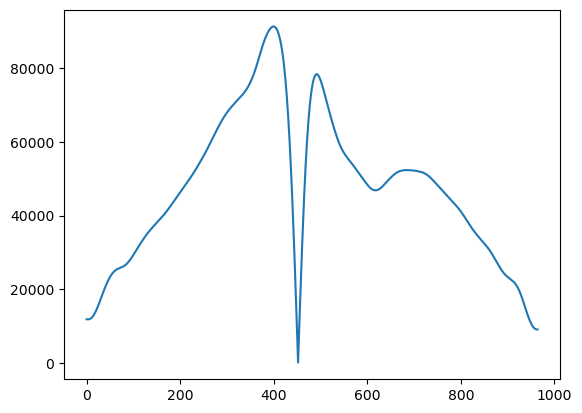

In [13]:
plt.plot(np.abs(p_xint))

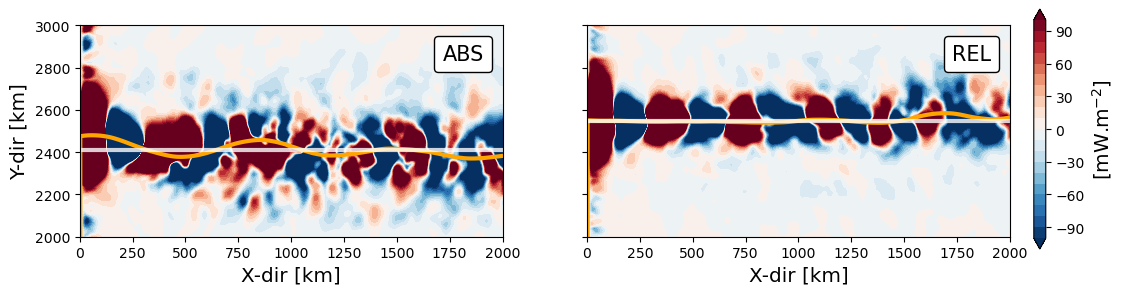

In [18]:
#-- P_EF (zoom) --
saveF = True
llev = np.arange(-100, 110, 10)
scaleF = rho*1e3
units = "mW.m$^{-2}$"
cbtype = 'both'
cmap = 'RdBu_r'
zz1 = -lec_abs["epe2mpe_map"] 
zz2 = -lec_rel["epe2mpe_map"]
nxp = 400
offset = 20
p_xint_abs = p_me_abs[0, offset:-offset, 1:nxp].mean(axis=-1)
jjj_abs = np.where( np.abs(p_xint_abs) == np.abs(p_xint_abs).min() )[0] + offset
p_xint_rel = p_me_rel[0, offset:-offset, 1:nxp].mean(axis=-1)
jjj_rel = np.where( np.abs(p_xint_rel) == np.abs(p_xint_rel).min() )[0] + offset
#
fig = plt.figure(figsize=(12, 4))
#
ax1 = fig.add_subplot(1, 2, 1, adjustable='box', aspect=1)
cs1 = ax1.contourf(xx, yy, zz1*scaleF, levels=llev, extend=cbtype, cmap=cmap)
ax1.contour(xx, yy, p_me_abs[0, ...], levels=[0], colors='orange', linewidths=3)
ax1.plot(xx[:nxp], np.ones(nxp)*yy[jjj_abs], color='white', alpha=0.8, lw=3)
at1 = AnchoredText(r"ABS", prop=dict(size=15), frameon=True, loc='upper right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)
ax1.set_xlabel('X-dir [km]', fontsize='x-large')
ax1.set_ylabel('Y-dir [km]', fontsize='x-large')
ax1.set_xlim([0, 2000])
ax1.set_ylim([2000, 3000])
#
ax2 = fig.add_subplot(1, 2, 2, adjustable='box', aspect=1)
cs2 = ax2.contourf(xx, yy, zz2*scaleF, levels=llev, extend=cbtype, cmap=cmap)
ax2.contour(xx, yy, p_me_rel[0, ...], levels=[0], colors='orange', linewidths=3)
ax2.plot(xx[:nxp], np.ones(nxp)*yy[jjj_rel], color='white', alpha=0.8, lw=3)
at2 = AnchoredText(r"REL", prop=dict(size=15), frameon=True, loc='upper right')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)
ax2.set_xlabel('X-dir [km]', fontsize='x-large')
ax2.set_yticklabels([])
ax2.set_xlim([0, 2000])
ax2.set_ylim([2000, 3000])
#
cb = fig.add_axes([0.92, 0.2, 0.01, 0.6])
cb = fig.colorbar(cs1, ax=ax1, orientation='vertical', cax=cb)
cb.set_label(str(r"[%s]" % (units)), fontsize='x-large')
#
if saveF:
    figN = str( "%s/p_ef_abs_rel_run12_dt10_zoom" % (dir_fig) )
    fig.savefig(str("%s.png" % (figN)), bbox_inches='tight')
    fig.savefig(str("%s.pdf" % (figN)), bbox_inches='tight')

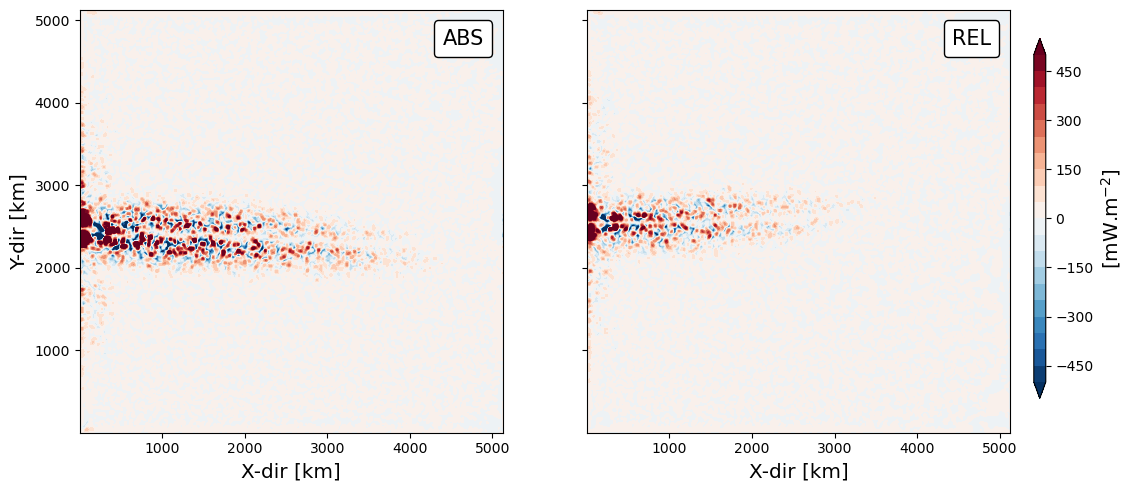

In [19]:
#-- K_MEC --
filt_width = 9
std = filt_width//2
xg = np.linspace(-std, std, filt_width)
xg, yg = np.meshgrid(xg, xg, indexing='xy')
gkerl = np.exp(-(xg**2 + yg**2) / (std**2)) / (np.pi*std**2)
gkerl /= gkerl.sum()
tmp_abs = signal.convolve2d(lec_abs["mke2eke_map"], gkerl, mode='same', boundary='wrap')
tmp_rel = signal.convolve2d(lec_rel["mke2eke_map"], gkerl, mode='same', boundary='wrap')
figN = str( "%s/k_mec_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, tmp_abs, tmp_rel, \
       np.arange(-500, 550, 50), "[mW.m$^{-2}$]", False, figN, cbtype='both')

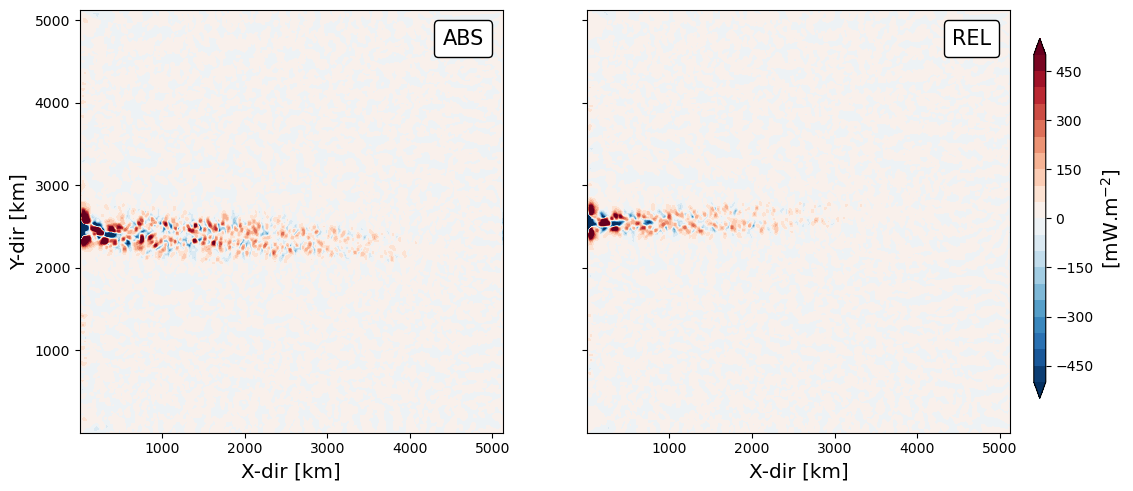

In [20]:
#-- K_EF --
tmp_abs = signal.convolve2d(lec_abs["eke2mke_map"], gkerl, mode='same', boundary='wrap')
tmp_rel = signal.convolve2d(lec_rel["eke2mke_map"], gkerl, mode='same', boundary='wrap')
figN = str( "%s/k_ef_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, tmp_abs, tmp_rel, \
       np.arange(-500, 550, 50), "[mW.m$^{-2}$]", False, figN, cbtype='both')

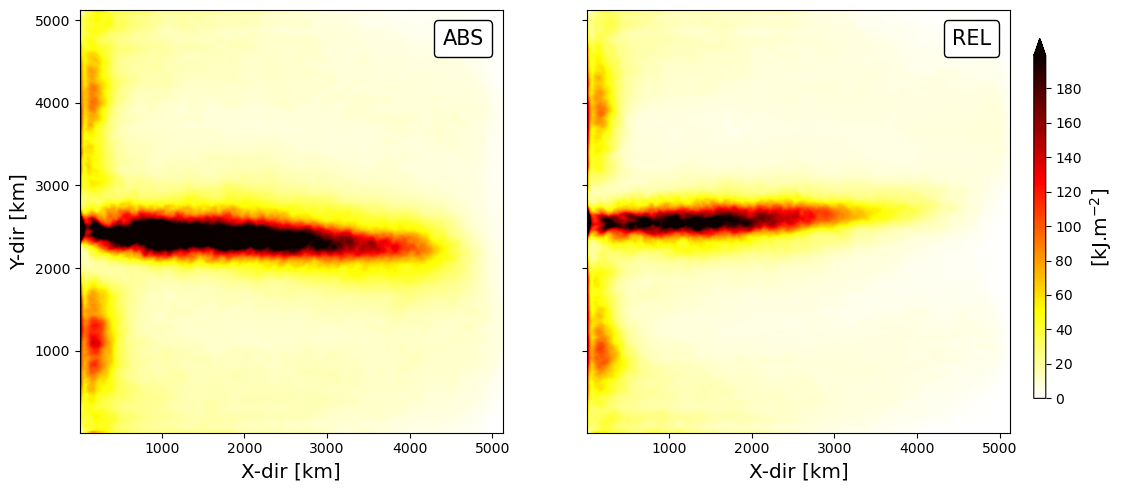

In [38]:
#-- EKE --
figN = str( "%s/eke_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx[1:], yy[1:], lec_abs["eke_map"]*1e-6, lec_rel["eke_map"]*1e-6, \
       np.arange(0, 200, 1), "[kJ.m$^{-2}$]", False, figN, cbtype='max')

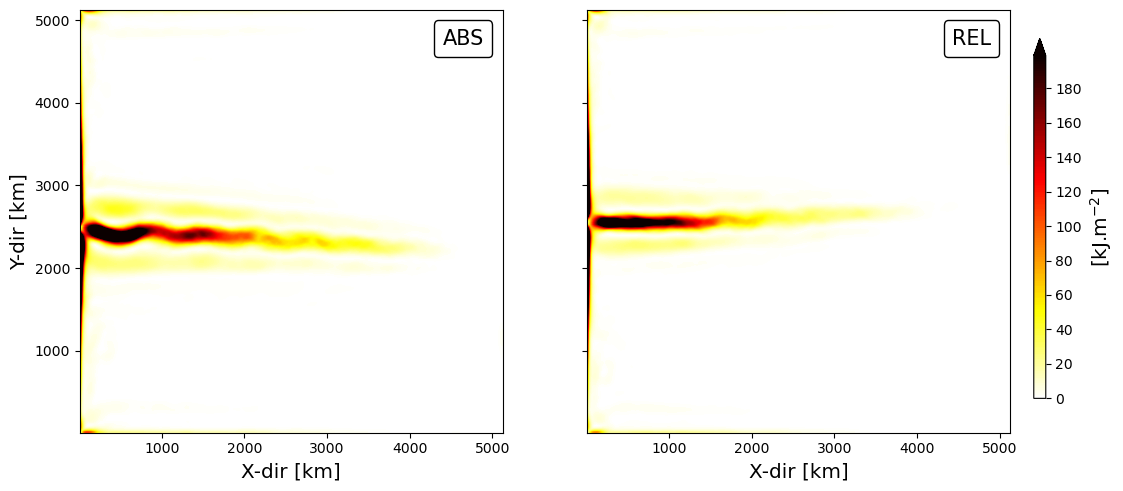

In [39]:
#-- MKE --
figN = str( "%s/mke_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx[1:], yy[1:], lec_abs["mke_map"]*1e-6, lec_rel["mke_map"]*1e-6, \
       np.arange(0, 200, 1), "[kJ.m$^{-2}$]", False, figN, cbtype='max')

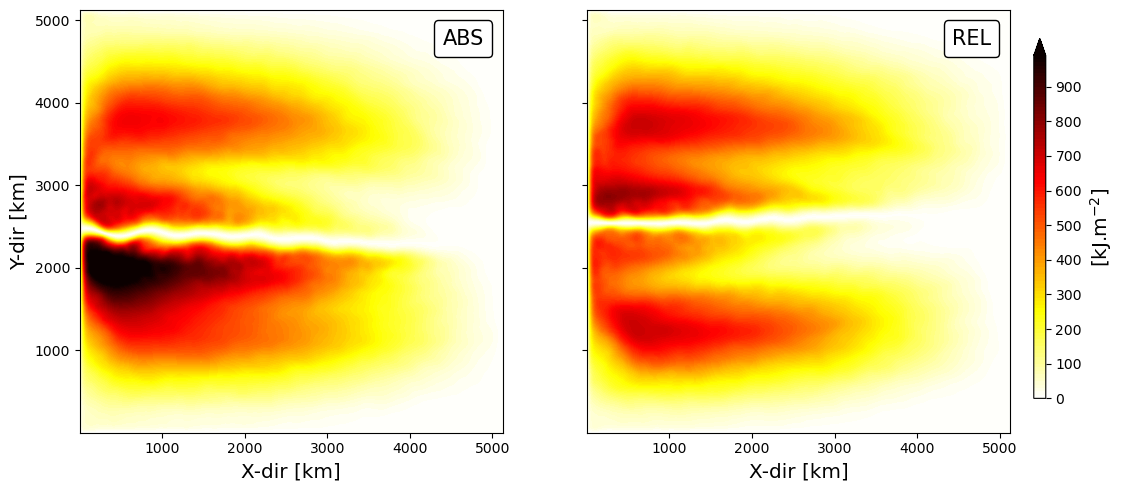

In [40]:
#-- MPE --
figN = str( "%s/mpe_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, lec_abs["mpe_map"]*1e-6, lec_rel["mpe_map"]*1e-6, \
       np.arange(0, 1000, 10), "[kJ.m$^{-2}$]", False, figN, cbtype='max')

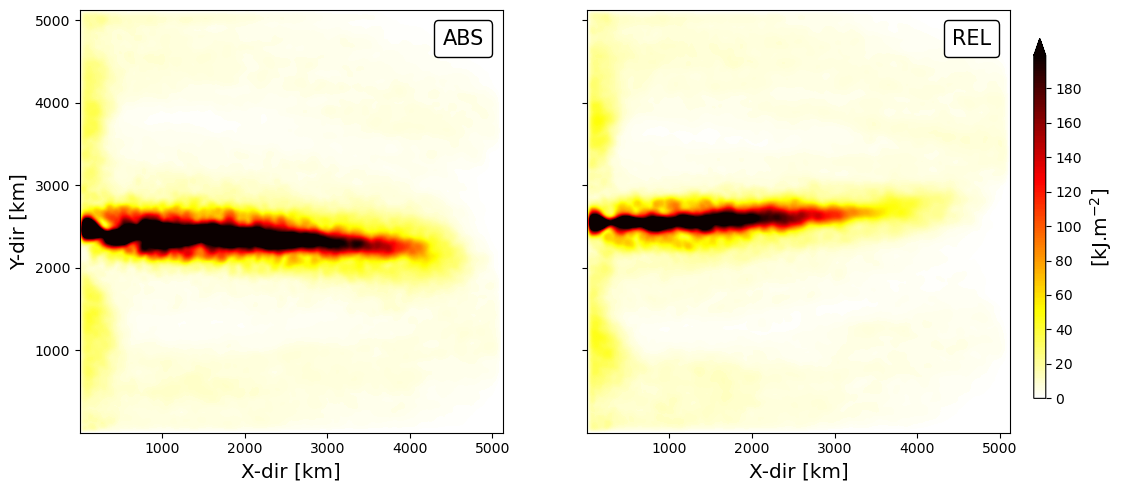

In [41]:
#-- EPE --
figN = str( "%s/epe_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, lec_abs["epe_map"]*1e-6, lec_rel["epe_map"]*1e-6, \
       np.arange(0, 200, 1), "[kJ.m$^{-2}$]", False, figN, cbtype='max')

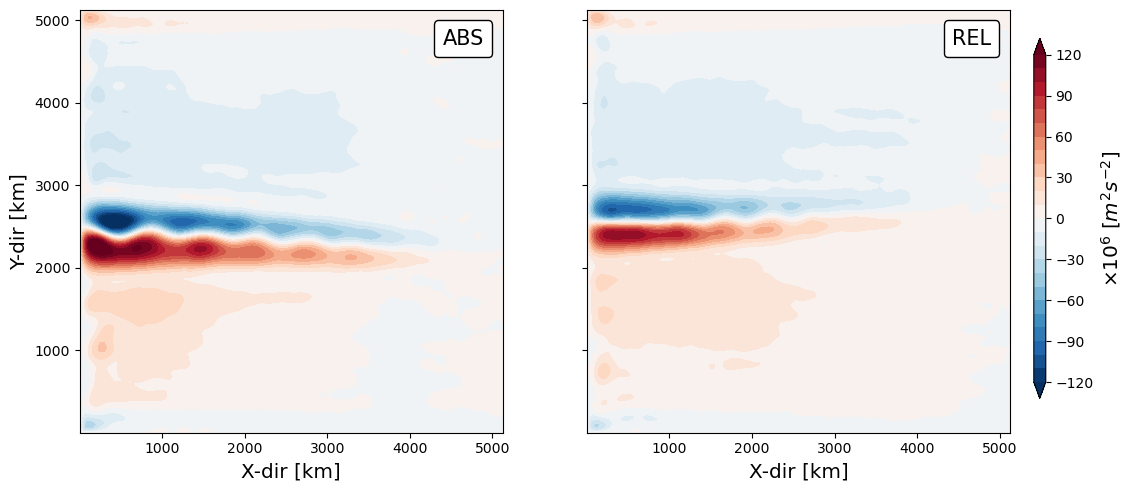

In [20]:
#-- mean pressure --
figN = str( "%s/pmean_abs_rel_run12_dt10" % (dir_fig) )
fig2hz(xx, yy, intz(p_me_abs, dh)*1e-12, intz(p_me_rel, dh)*1e-12, \
       np.arange(-120, 130, 10), r"$\times10^6$ [$m^2 s^{-2}$]", True, figN, cbtype='both')

# Spectral flux

In [21]:
def plot_spectra(kkk, tmp1, tmp2, scaleF, llab, saveF, figN):
    '''
    Plot spectral flux of absolute (tmp1) and relative (tmp2) simulations.
    '''
    fig1, ax1 = plt.subplots(1, 1, figsize = (8,4), tight_layout=True)
    #
    p0 = ax1.plot(kkk*1000, tmp1*scaleF, color='k', linewidth=3)
    p1 = ax1.plot(kkk*1000, tmp2*scaleF, color='r', linewidth=3)
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$k$ [cpkm]')
    ax1.set_ylabel(r'Spectral flux [$\times$%.00e m$^2$s$^{-3}$]' % (1/scaleF))
    ax1.legend((p0[0], p1[0]), ('ABS', 'REL'))
    at1 = AnchoredText(llab, prop=dict(size=15), frameon=True, loc='center right')
    at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at1)
    plt.grid()
    ax1.set_xlim([min(kkk*1000), max(kkk*1000)])
    if saveF:
        fig1.savefig(str("%s.png" % (figN)), bbox_inches='tight')
        fig1.savefig(str("%s.pdf" % (figN)), bbox_inches='tight')

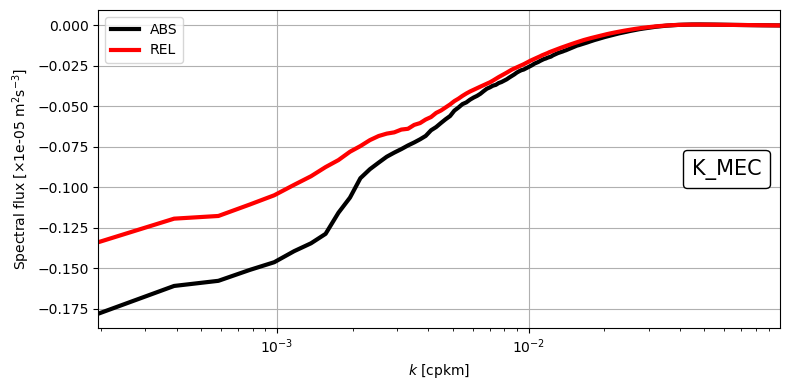

In [22]:
#-- mke2eke --
figN = str("%s/spectra_mke2eke_dt10_run12" % (dir_fig))
plot_spectra(lec_abs["k"], -lec_abs["mke2eke_spflx"], -lec_rel["mke2eke_spflx"], \
             1e5, 'K_MEC', False, figN)

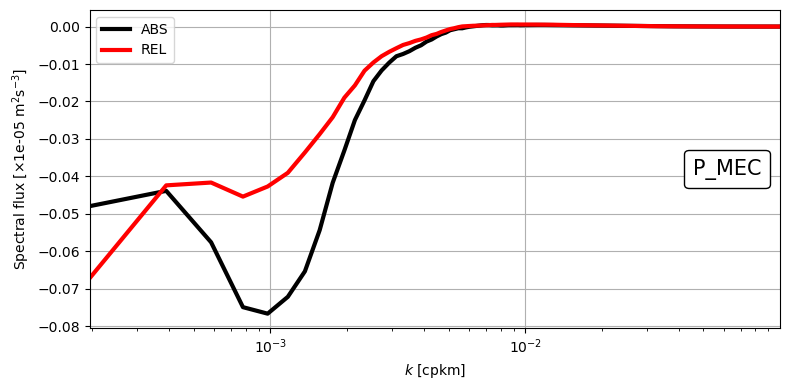

In [24]:
#-- mpe2epe --
figN = str("%s/spectra_mpe2epe_dt10_run12" % (dir_fig))
plot_spectra(lec_abs["k"], -lec_abs["mpe2epe_spflx"], -lec_rel["mpe2epe_spflx"], \
             1e5, 'P_MEC', True, figN)

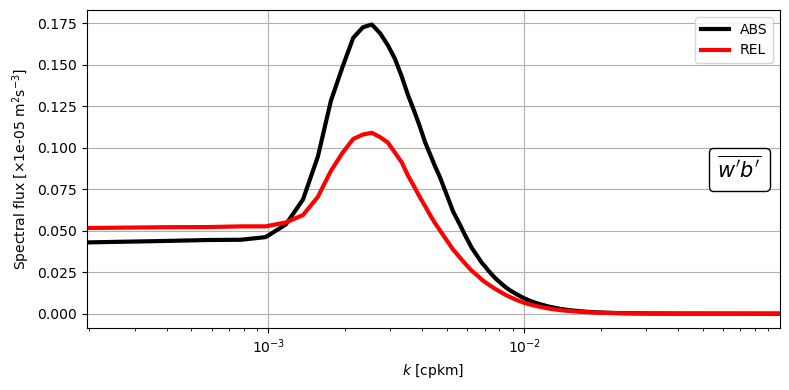

In [9]:
#-- epe2eke --
figN = str("%s/spectra_epe2eke_dt10_run12" % (dir_fig))
plot_spectra(lec_abs["k"], lec_abs["epe2eke_spflx"], lec_rel["epe2eke_spflx"], \
             1e5, r"$\overline{w'b'}$", True, figN)

In [36]:
np.ones((3, 2, 2)).ndim

3

----------------------
----------------------